In [82]:
!pip install gymnasium torch_geometric

In [2]:
import torch

## Playground

In [60]:
# num employees one hot encoded. 1 feature describing the job (0 is doctor, 1 is nurse)
employees = torch.tensor([[1],[1],[1],[1],[1]])
employees = employees.to(torch.float)

In [61]:
# shift nodes one hot encoded. 6 classes for weekday (one class is dropped to reduce collinearity) and 1 class for night/day shift.
shifts = list()
shifts.append(torch.tensor([0,0,0,0,0,0,0])) # Monday, day
shifts.append(torch.tensor([0,0,0,0,0,0,1])) # Monday, night
shifts.append(torch.tensor([1,0,0,0,0,0,0])) # Tuesday, day
shifts.append(torch.tensor([1,0,0,0,0,0,1])) # Tuesday, night
shifts.append(torch.tensor([0,1,0,0,0,0,0])) # Wednesday, day
shifts.append(torch.tensor([0,1,0,0,0,0,1])) # Wednesday, night
shifts.append(torch.tensor([0,0,1,0,0,0,0])) # Thursday, day
shifts.append(torch.tensor([0,0,1,0,0,0,1])) # Thursday, night
shifts.append(torch.tensor([0,0,0,1,0,0,0])) # Friday, day
shifts.append(torch.tensor([0,0,0,1,0,0,1])) # Friday, night
shifts.append(torch.tensor([0,0,0,0,1,0,0])) # Saturday, day
shifts.append(torch.tensor([0,0,0,0,1,0,1])) # Saturday, night
shifts.append(torch.tensor([0,0,0,0,0,1,0])) # Sunday, day
shifts.append(torch.tensor([0,0,0,0,0,1,1])) # Sunday, night
shifts = torch.vstack(shifts)
shifts = shifts.to(torch.float)

In [62]:
# create edges from employees to shifts
assignments = torch.tensor([[1,2,3],[2,3,4]], dtype=torch.int64)
assignments = torch.tensor([[],[]], dtype=torch.int64)

In [63]:
# create graph
from torch_geometric.data import HeteroData
data=HeteroData()
data["employee"].x = employees
data["shift"].x = shifts
data['employee', 'assigned', 'shift'].edge_index = assignments
if data.validate(raise_on_error=True):
    print("Data validation successful") 
else: 
    raise ValueError("Data validation not successful")

print("The graph has ", data.num_nodes, " nodes")
print("The graph has ", data.num_edges, " edges")

Data validation successful
The graph has  19  nodes
The graph has  0  edges


In [7]:
# create models
from torch_geometric.nn import RGCNConv 
gnn_employees = RGCNConv(in_channels = (1,7), out_channels=2, num_relations=1)
gnn_shifts = RGCNConv(in_channels = (7,1), out_channels=2, num_relations=1)

In [8]:
# encode nodes
out_shifts = gnn_employees(x=(data.x_dict["employee"], data.x_dict["shift"]), edge_index=data["assigned"]["edge_index"], edge_type=torch.zeros(data["assigned"]["edge_index"].shape[1], dtype=torch.int64))

assignments_flipped=torch.vstack((data["assigned"]["edge_index"][1], data["assigned"]["edge_index"][0])) 
out_employees = gnn_shifts(x=(data.x_dict["shift"], data.x_dict["employee"]), edge_index=assignments_flipped, edge_type=torch.zeros(data["assigned"]["edge_index"].shape[1], dtype=torch.int64))

In [9]:
# decoder class
import itertools
class decoder():
    def __init__(self):
        pass
    def decode(self, emb_employees, emb_shifts):
        num_employees = emb_employees.shape[0]
        num_shifts = emb_shifts.shape[0]

        scores = list()
        for p in itertools.product(range(num_employees), range(num_shifts)):
            score = torch.dot(emb_employees[p[0]], emb_shifts[p[1]])
            scores.append(((p[0], p[1]),score))

        # returns list of tuples containting the dot product and the indicies of the two nodes
        return scores  

In [10]:
# decode embeddings (calculating scores)
dec = decoder()
scores = dec.decode(out_employees, out_shifts)

## Reinforcement Learning Environment

In [277]:
# RL env bauen
from collections import Counter
from typing import Tuple

import gymnasium as gym
from torch_geometric.data import HeteroData

class personnelScheduleEnv(gym.Env):
    def __init__(self, employees: torch.tensor, shifts: torch.tensor, assignments: torch.tensor) -> None:        
        # setup graph
        self.initial_state=HeteroData()
        self.initial_state["employee"].x = employees
        self.initial_state["shift"].x = shifts
        self.initial_state["employee", "assigned", "shift"].edge_index = assignments
        if self.initial_state.validate(raise_on_error=True):
            print("Data validation successful") 
        else: 
            raise ValueError("Data validation not successful")
        print("The graph has ", self.initial_state.num_nodes, " nodes")
        print("The graph has ", self.initial_state.num_edges, " edges")

        self.action_space = gym.spaces.Tuple((gym.spaces.Discrete(employees.shape[0]), gym.spaces.Discrete(shifts.shape[0])))
        self.num_employees = self.initial_state["employee"].x.shape[0]
        self.num_shifts = self.initial_state["shift"].x.shape[0]

    def _get_num_consecutive_violations(self) -> int:
        planning = self.get_current_planning()
        num_consecutive_violations = 0
        for i in range(self.num_shifts-1): 
            num_consecutive_violations = num_consecutive_violations + (Counter(planning[i])-(Counter(planning[i])-Counter(planning[i+1]))).total()  
        return num_consecutive_violations

    def get_num_planned_shifts(self) -> int:
        return self.state["assigned"].edge_index.shape[1]
            
    def get_current_planning(self) -> dict:
        planning = dict() 
        for i in range(self.num_shifts):
            planning[i] = list()
        for i in torch.arange(self.state["assigned"].edge_index.shape[1]): 
            planning[self.state["assigned"].edge_index[:, i][1].item()].append(self.state["assigned"].edge_index[:, i][0].item())
        return planning

    def info(self) -> dict:
        return {}
        
    def step(self, action: tuple[int, int]) -> tuple[HeteroData, float, bool, bool, dict]:
        if not self.action_space.contains(action):
            return (self.state, self.reward(), self.terminated(), self.truncated(), self.info())

        action = torch.tensor(action) 
        mask = torch.ones(self.state["assigned"].edge_index.shape[1], dtype=torch.bool)
        for i in torch.arange(self.state["assigned"].edge_index.shape[1]): 
            if torch.equal(self.state["assigned"].edge_index[:,i], action):
                mask[i] = False
        self.state["assigned"].edge_index = self.state["assigned"].edge_index[:,mask] 
        if not (~mask).any():
            self.state["assigned"].edge_index = torch.hstack((self.state["assigned"].edge_index, action[:,None]))
            
        return (self.state, self.reward(), self.terminated(), self.truncated(), self.info())

    def reset(self, seed: int = None) -> tuple[HeteroData, dict]:
        super().reset(seed=seed)
        self.state = self.initial_state
        return (self.state, self.info())

    def reward(self) -> float:
        reward = 0
        reward = reward + self.get_num_planned_shifts()
        reward = reward - 10*self._get_num_consecutive_violations()
        if self.terminated():
            reward = reward + 1000
        return reward

    def terminated(self) -> bool:
        terminated = True
        planning = self.get_current_planning()
        for i in range(self.num_shifts-1): 
            if len(planning[i])<2:
                terminated = False
                break
        return terminated

    def truncated(self) -> bool:
        return False

In [285]:
# num employees one hot encoded. 1 feature describing the job (0 is doctor, 1 is nurse)
employees = torch.tensor([[1],[1],[1],[1],[1]])
employees = employees.to(torch.float)

In [286]:
# shift nodes one hot encoded. 6 classes for weekday (one class is dropped to reduce collinearity) and 1 class for night/day shift.
shifts = list()
shifts.append(torch.tensor([0,0,0,0,0,0,0])) # Monday, day
shifts.append(torch.tensor([0,0,0,0,0,0,1])) # Monday, night
shifts.append(torch.tensor([1,0,0,0,0,0,0])) # Tuesday, day
shifts.append(torch.tensor([1,0,0,0,0,0,1])) # Tuesday, night
shifts.append(torch.tensor([0,1,0,0,0,0,0])) # Wednesday, day
shifts.append(torch.tensor([0,1,0,0,0,0,1])) # Wednesday, night
shifts.append(torch.tensor([0,0,1,0,0,0,0])) # Thursday, day
shifts.append(torch.tensor([0,0,1,0,0,0,1])) # Thursday, night
shifts.append(torch.tensor([0,0,0,1,0,0,0])) # Friday, day
shifts.append(torch.tensor([0,0,0,1,0,0,1])) # Friday, night
shifts.append(torch.tensor([0,0,0,0,1,0,0])) # Saturday, day
shifts.append(torch.tensor([0,0,0,0,1,0,1])) # Saturday, night
shifts.append(torch.tensor([0,0,0,0,0,1,0])) # Sunday, day
shifts.append(torch.tensor([0,0,0,0,0,1,1])) # Sunday, night
shifts = torch.vstack(shifts)
shifts = shifts.to(torch.float)

In [287]:
# create edges from employees to shifts
#assignments = torch.tensor([[1,2,3],[2,3,4]], dtype=torch.int64)
assignments = torch.tensor([[],[]], dtype=torch.int64)

In [288]:
env = personnelScheduleEnv(employees=employees, shifts=shifts, assignments=assignments)
env.reset()

Data validation successful
The graph has  7  nodes
The graph has  0  edges


(HeteroData(
   employee={ x=[5, 1] },
   shift={ x=[2, 7] },
   (employee, assigned, shift)={ edge_index=[2, 0] }
 ),
 {})

In [295]:
env.step((1,0))

(HeteroData(
   employee={ x=[5, 1] },
   shift={ x=[2, 7] },
   (employee, assigned, shift)={ edge_index=[2, 4] }
 ),
 984,
 True,
 False,
 {})

In [293]:
env.state["assigned"].edge_index

tensor([[0, 0],
        [0, 1]])

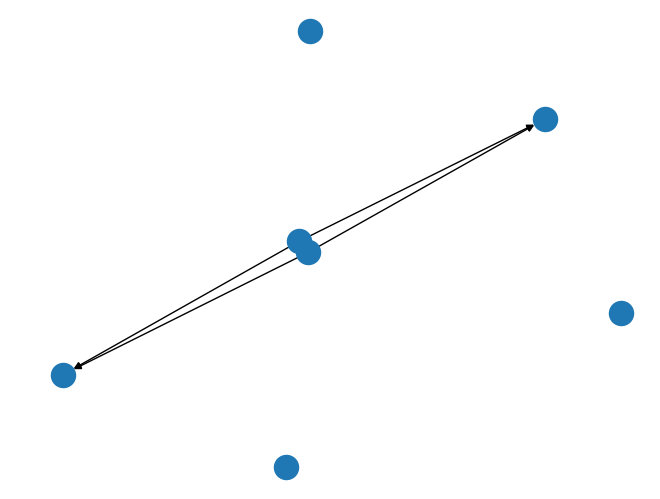

In [296]:
import networkx as nx 
from torch_geometric.utils import to_networkx

g=to_networkx(env.state)
nx.draw(g)